# Digit Recognition Neural Network

## Importing Libraries

In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

## Edit input images to make them all have the same size etc (pre-processing data)

- For this task we will be using torchvsion

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

## Downloading Dataset

In [3]:
trainset = datasets.MNIST('./', download=True, train=True, transform=transform)
valset = datasets.MNIST('./', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



## Getting to know the dataset better

In [8]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


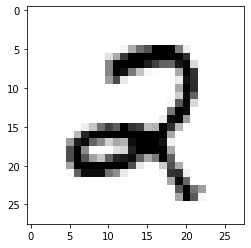

In [9]:
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r');

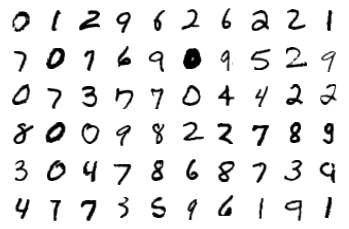

In [12]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

## Building the Neural Network

In [15]:
input_size = 784 # (28*28), number of pixels
hidden_sizes = [128, 64] # numero de parametros das cells intermediarias
output_size = 10 # Numero de digitos possiveis para a previsao


In [16]:
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))

In [17]:
model

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)

The `nn.Sequential` wraps the layers in the newtwork. We have 3 layers with ReLU activatio\
(this is a function that allows positive values to go trough and turns negative ones to zero). We use the `LogSoftmax` activation because this is a classification problem

In [18]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

## Adjusting the Neural Network

In [19]:
print('Before backward pass: \n', model[0].weight.grad)
loss.backward()
print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[ 0.0008,  0.0008,  0.0008,  ...,  0.0008,  0.0008,  0.0008],
        [ 0.0020,  0.0020,  0.0020,  ...,  0.0020,  0.0020,  0.0020],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.0001, -0.0001, -0.0001,  ..., -0.0001, -0.0001, -0.0001],
        [ 0.0007,  0.0007,  0.0007,  ...,  0.0007,  0.0007,  0.0007],
        [-0.0003, -0.0003, -0.0003,  ..., -0.0003, -0.0003, -0.0003]])


## Core Training

After making a minor adjustment of the weights in the prevous step, we come to the where the actual magic begins.\
- We make use of `torch.optim` to optimize the model, perform gradient descent and update the weigths once again, this time with back-propagation so in each `epoch` that is the number of times we iterate over the training set, we should be getting a gradual decrease in training loss.

Essentially, we are training the model 15 times with the same data to maximise accuracy.

In [20]:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 15
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 0.6551248726528337
Epoch 1 - Training loss: 0.2811000070639892
Epoch 2 - Training loss: 0.21854384888463946
Epoch 3 - Training loss: 0.17880544680029725
Epoch 4 - Training loss: 0.15102789103428818
Epoch 5 - Training loss: 0.12864145983471229
Epoch 6 - Training loss: 0.1123059958672282
Epoch 7 - Training loss: 0.10024509254072521
Epoch 8 - Training loss: 0.09016151748287843
Epoch 9 - Training loss: 0.08069416121748496
Epoch 10 - Training loss: 0.07331271342107101
Epoch 11 - Training loss: 0.0680983209459266
Epoch 12 - Training loss: 0.06176863950855935
Epoch 13 - Training loss: 0.05711032223350593
Epoch 14 - Training loss: 0.05211208698608831

Training Time (in minutes) = 5.567632611592611


## Testing and Evaluating the Model

In [22]:
def view_classify(img, ps):
    ps = ps.cpu().data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

Predicted Digit = 1


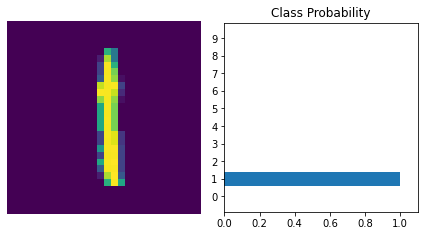

In [32]:
images, labels = next(iter(valloader))

img = images[0].view(1, 784)
with torch.no_grad():
    logps = model(img)

ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.view(1, 28, 28), ps)

In [34]:
correct_count, all_count = 0, 0
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    with torch.no_grad():
        logps = model(img)

    
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.9748
